In [1]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
import nltk
import pandas as pd
import re
import random

# Load Data

In [6]:
articles = pd.read_csv('./Data/New_Full-Economic-News-DFE-839861.csv')

In [8]:
articles.text.head()

0    NEW YORK -- Yields on most certificates of dep...
1    The Wall Street Journal Online</br></br>The Mo...
2    WASHINGTON -- In an effort to achieve banking ...
3    The statistics on the enormous costs of employ...
4    NEW YORK -- Indecision marked the dollar's ton...
Name: text, dtype: object

In [9]:
#Text cleaning to remove numbers and special charaters
def Word_cleaning(entry):
    entry_low = entry.lower()
    Only_words = re.sub('[^a-z]+', ' ', entry_low).strip()
    #words = Only_words.split()
    
    return(Only_words)

In [12]:
articles["Text_Clean"] = articles["text"].apply(lambda item: Word_cleaning(str(item)))

In [13]:
Clean_Text = articles["Text_Clean"].tolist()

In [14]:
stopwords = nltk.corpus.stopwords.words('english')
len_filter = 2

In [15]:
Final_Text = [[word for word in document.split() if (word not in stopwords) and (len(word)>len_filter)]
         for document in Clean_Text]

In [16]:
dictionary = corpora.Dictionary(Final_Text)

In [17]:
dictionary.filter_extremes(no_below=5, no_above=0.5)
dictionary.compactify()

In [18]:
corpus = [dictionary.doc2bow(doc) for doc in Final_Text]

In [19]:
print(corpus[0])

[(0, 2), (1, 2), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 4), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 3), (23, 3), (24, 2), (25, 1), (26, 2), (27, 2), (28, 2), (29, 4), (30, 2), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1)]


In [20]:
corpora.MmCorpus.serialize('Economic_news.mm', corpus)

In [21]:
dictionary.save('Economic_news.dict')

# Fit the LDA Model

In [22]:
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=30, passes=20)

In [29]:
#Show log_perplexity

lda.log_perplexity(corpus)

-7.8097142323359838

In [23]:
print(lda.print_topics(num_topics=3, num_words=3))

[(9, '0.227*"per" + 0.163*"cent" + 0.032*"carter"'), (1, '0.086*"mexico" + 0.030*"mexican" + 0.030*"communist"'), (0, '0.053*"war" + 0.020*"iraq" + 0.017*"military"')]


In [24]:
lda.save('Economic_news.model')

# Visualization

In [52]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [26]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/Applications/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


# Load Saved Dictionary and Corpus

In [2]:
dictionary = corpora.dictionary.Dictionary.load('Economic_news.dict')
corpus = corpora.MmCorpus('Economic_news.mm')

In [3]:
print(dictionary)

Dictionary(11909 unique tokens: ['new', 'york', 'yields', 'certificates', 'deposit']...)


In [4]:
print(corpus[0])

[(0, 2.0), (1, 2.0), (2, 2.0), (3, 1.0), (4, 1.0), (5, 1.0), (6, 1.0), (7, 3.0), (8, 1.0), (9, 1.0), (10, 2.0), (11, 2.0), (12, 1.0), (13, 4.0), (14, 1.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0), (19, 1.0), (20, 1.0), (21, 2.0), (22, 3.0), (23, 3.0), (24, 2.0), (25, 1.0), (26, 2.0), (27, 2.0), (28, 2.0), (29, 4.0), (30, 2.0), (31, 1.0), (32, 1.0), (33, 1.0), (34, 2.0), (35, 1.0), (36, 2.0), (37, 1.0), (38, 1.0), (39, 1.0), (40, 1.0), (41, 1.0), (42, 1.0), (43, 2.0), (44, 1.0), (45, 1.0), (46, 1.0), (47, 1.0), (48, 1.0), (49, 1.0), (50, 1.0), (51, 1.0), (52, 1.0), (53, 1.0), (54, 1.0), (55, 1.0), (56, 1.0), (57, 1.0), (58, 1.0), (59, 1.0), (60, 1.0), (61, 1.0), (62, 1.0), (63, 1.0), (64, 1.0)]


In [5]:
len(corpus)

8000

# Train-Test Split

In [6]:
# split into train and test - random sample, but preserving order
train_size = int(round(len(corpus)*0.8))
train_index = sorted(random.sample(range(len(corpus)), train_size))
test_index = sorted(set(range(len(corpus))) - set(train_index))

In [7]:
train_corpus = [corpus[i] for i in train_index]
test_corpus = [corpus[j] for j in test_index]
test_num_words = sum(cnt for document in test_corpus for _, cnt in document)

In [8]:
print(len(test_corpus))

1600


# Tune LDA Hyperparameters

In [9]:
# Candidates
ParameterLlist = {'iter': [100, 300, 500], 'topic_nums': range(1, 25, 1)}

In [10]:
ParameterLlist['topic_nums']

range(1, 25)

# Topic Coherence
## Umass
### Umass is based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure.
### The main idea of this coherence is that the occurrence of every top word should be supported by every top preceding top word. Thus, the probability of a top word to occur should be higher if a document already contains a higher order top word of the same topic. Therefore, for every word the logarithm of its conditional probability is calculated using every other top word that has a higher order in the ranking of top words as condition. The probabilities are derived using document cooccurrence counts. The single conditional probabilities are summarized using the arithmetic mean.

In [ ]:
#Initialize
Umass_100 = []
Umass_300 = []
Umass_500 = []
epsilon = 0.001

In [46]:
#for i in ParameterLlist['iter']:
i=500    
    
for j in ParameterLlist['topic_nums']:
    lda = models.LdaMulticore(corpus=train_corpus, id2word=dictionary, iterations=i, num_topics=j)   
    cm = models.CoherenceModel(model=lda, corpus=test_corpus, coherence='u_mass')
    
    try: 
        #print(cm.get_coherence())
        score = cm.get_coherence()
    except ZeroDivisionError:
        score = score - epsilon
        
    print(score)
        
    #Umass.append(cm.get_coherence())
    Umass_500.append(score)

-1.36089501149
-1.3315092546
-1.3680901388
-1.30032112941
-1.39123647437
-1.37238371663
-1.39009635779
-1.45367231787
-1.42821177068
-1.50839427082
-1.51411421485
-1.48539052199
-1.55964695626
-1.56377399807
-1.49679265865
-1.50790911894
-1.4676255835
-1.49529742407
-1.57372535063
-1.67883334474
-1.49472484715
-1.59510212013
-1.69176993682
-1.50390742627


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

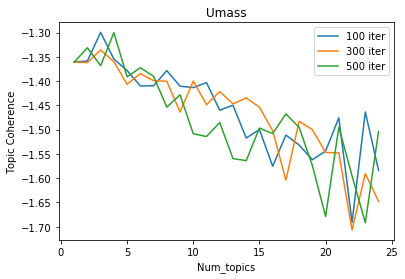

In [51]:
x = ParameterLlist['topic_nums']
plt.plot(x, Umass_100)
plt.plot(x, Umass_300)
plt.plot(x, Umass_500)
plt.xlabel("Num_topics")
plt.ylabel("Topic Coherence")
plt.legend(['100 iter','300 iter', '500 iter'], loc='upper right')
plt.title('Umass')
plt.show()

## Visualize (iterations=500 and num_topics=4)

In [54]:
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

/Applications/anaconda/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  topic_term_dists = topic_term_dists.ix[topic_order]


## C_v
### C_v is based on a sliding window, a one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosinus similarity.

### This coherence measure retrieves cooccurrence counts for the given words using a sliding window and the window size 110. The counts are used to calculated the NPMI of every top word to every other top word, thus, resulting in a set of vectors—one for every top word. The one-set segmentation of the top words leads to the calculation of the similarity between every top word vector and the sum of all top word vectors. 

In [ ]:
c_v = []
#lm_list = []

#for i in ParameterLlist['iter']:
i=300   

for j in ParameterLlist['topic_nums']:
    lda = models.LdaMulticore(corpus=corpus, id2word=dictionary, iterations=i, num_topics=j)   
    cm = models.CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence='c_v')  #need to texts here
    c_v.append(cm.get_coherence())

    